<h1 align="center" style="color:brown;font-size:300%">Lab 5 : Radial Basis Functions - Part 2</h1>


<div class="alert alert-block alert-info">
<b style="font-size:200%;">Question 3:</b> 
    Design and implement a handwritten character-recognition algorithm using RBF neural
networks. As part of the project design process, you will define the problem specifications. This
will include:
    

- **Defining a uniform format for generating input data for training and testing.**
  - To simplify the problem, handwritten character samples can be expected to conform to a uniform size (all characters can be written inside of a 1"x1" block for example).
  - The characters may be in the Palm Computing Platform's Graffitti(R)2 format (see [http://www.palm.com/us/support/handbooks/graffiti2_sticker.pdf](http://www.palm.com/us/support/handbooks/graffiti2_sticker.pdf) for details).

- **Defining the number and type of characters to be recognized.**

- **Defining the sample data collection process:**
  - How many people?
  - How many samples from each?

- **Other suitable problem specifications for developing a justifiable character recognition system.**
    
    
    
</div>

In [1]:
!pip install -q tensorflowjs

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requir

In [2]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

2024-07-29 21:42:43.431427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 21:42:43.431552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 21:42:43.554962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Read in Y labels from CSV

label_csv = '/kaggle/input/english-handwritten-characters-dataset/english.csv'
df_Y = pd.read_csv(label_csv)

In [4]:
# Read images and write with label to arrays

images_path = "/kaggle/input/english-handwritten-characters-dataset/Img"
images = []
labels = []

for image_path in os.listdir(images_path):
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') # Read image as a float32 object
    image = cv.resize(image, (64, 64)) # Resize to smaller size for faster train time
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Convert to greyscale for faster train time
    image /= 255.0 # Normalise data
    
    label_index = os.path.join("Img", image_path) # Get index into df_Y
    label = df_Y[df_Y['image'] == label_index].label.values[0] # Get label value
    
    # Write into arrays
    images.append(image)
    labels.append(label)

In [5]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

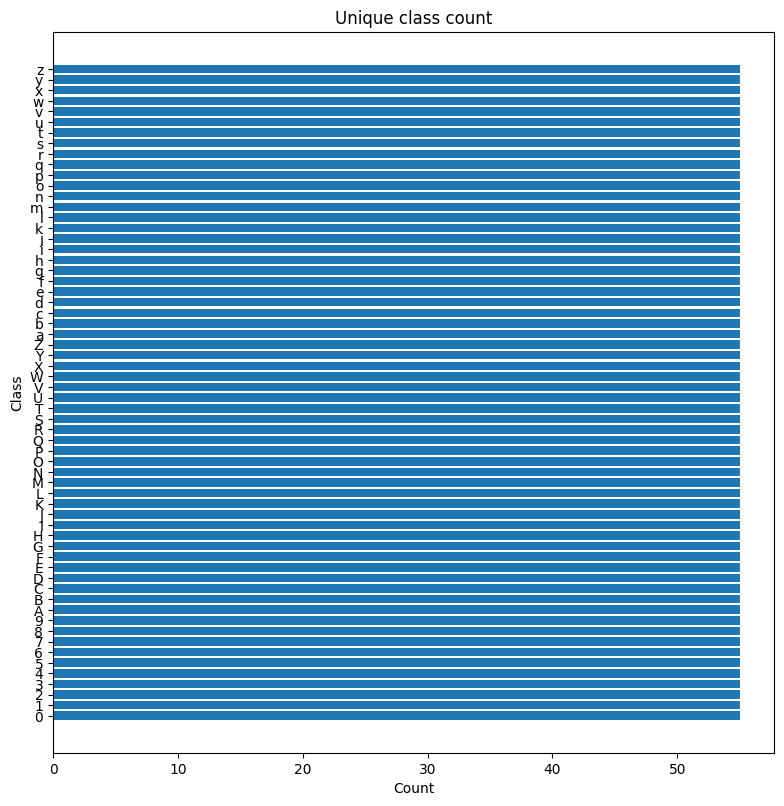

In [6]:
# Visualise the count for each class

unique_class, class_count = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique_class, class_count)
plt.tight_layout(pad=2.0)
plt.title("Unique class count")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

In [7]:
# Add greyscale dimension for cnn

images = np.expand_dims(images, axis=-1) 

In [8]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [9]:
# Define a custom decoder

decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

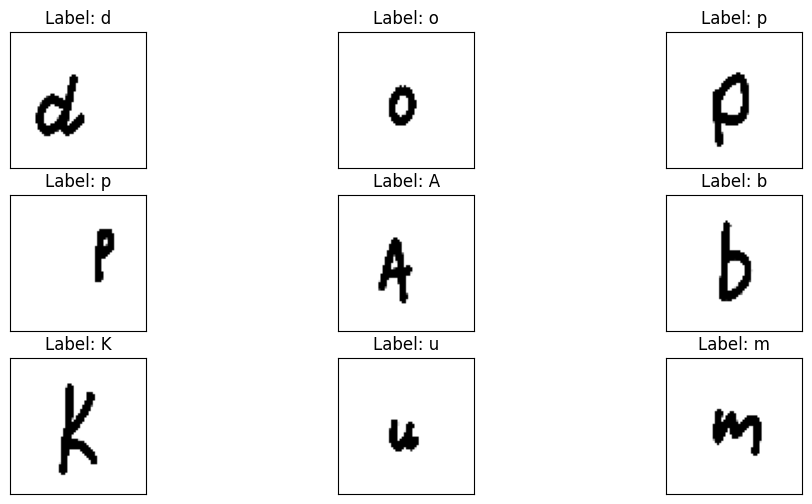

In [10]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

In [11]:
# Randomly shuffle the data

images, labels = shuffle(images, labels, random_state=0)

In [12]:
# Split the data into train, test and validation sets (70, 15, 15)

X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [13]:
# Define augmentation generator

datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range= 0.2, 
    shear_range=0.2,               
    fill_mode='nearest',        
)

In [14]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image_expanded = np.expand_dims(X_train[i], axis=0)  
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)  
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation) 

In [15]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [16]:
# Shuffle again

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

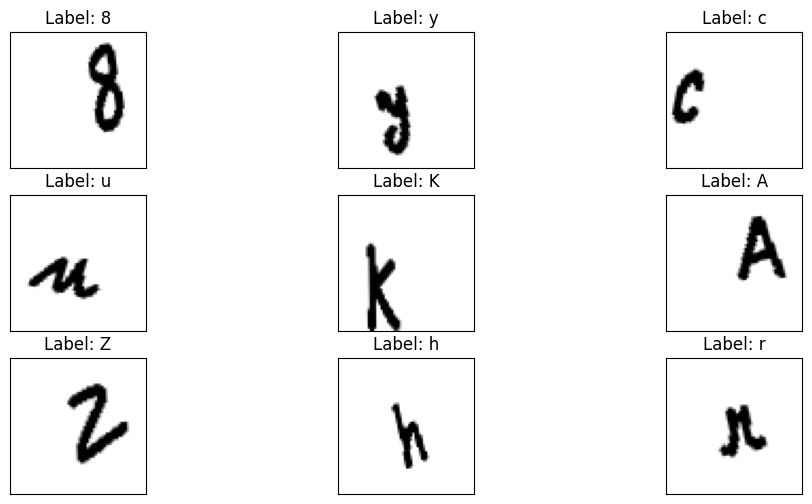

In [17]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [18]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(62, activation='softmax')
])

In [19]:
# Visualise model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 512)       13312     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0

In [20]:
# Compile and train the model

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/10


I0000 00:00:1722289442.127817      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


746/746 [==============================] - 24s 22ms/step - loss: 3.3955 - accuracy: 0.1055 - val_loss: 2.6105 - val_accuracy: 0.2016
Epoch 2/10
746/746 [==============================] - 15s 20ms/step - loss: 2.2453 - accuracy: 0.3122 - val_loss: 1.3842 - val_accuracy: 0.5382
Epoch 3/10
746/746 [==============================] - 15s 20ms/step - loss: 1.3285 - accuracy: 0.5775 - val_loss: 0.9922 - val_accuracy: 0.6693
Epoch 4/10
746/746 [==============================] - 15s 21ms/step - loss: 0.8041 - accuracy: 0.7365 - val_loss: 0.7138 - val_accuracy: 0.7554
Epoch 5/10
746/746 [==============================] - 15s 21ms/step - loss: 0.5638 - accuracy: 0.8083 - val_loss: 0.6774 - val_accuracy: 0.7847
Epoch 6/10
746/746 [==============================] - 16s 21ms/step - loss: 0.4264 - accuracy: 0.8494 - val_loss: 0.7262 - val_accuracy: 0.7652
Epoch 7/10
746/746 [==============================] - 16s 21ms/step - loss: 0.3434 - accuracy: 0.8788 - val_loss: 0.6369 - val_accuracy: 0.8043
Epo

In [21]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

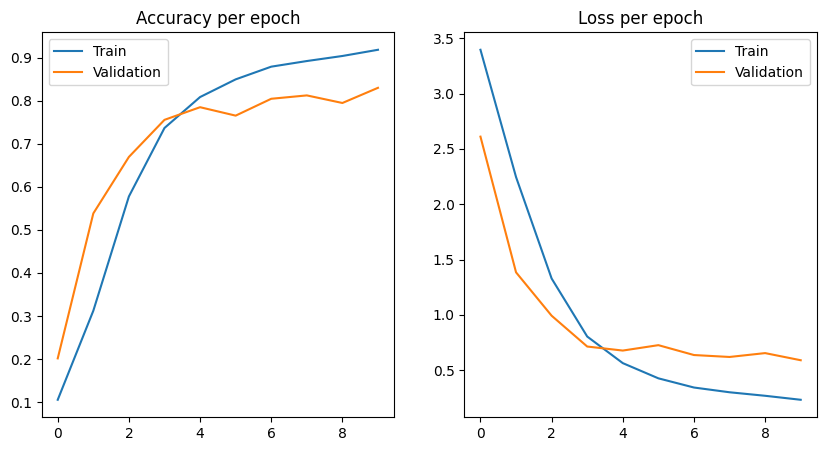

In [22]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Train', 'Validation'])
axes[0].set_title("Accuracy per epoch")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Train', 'Validation'])
axes[1].set_title("Loss per epoch")

plt.plot()

In [23]:
# Get test predictions

Y_pred = model.predict(X_test)

16/16 [==============================] - 1s 9ms/step


In [24]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8203


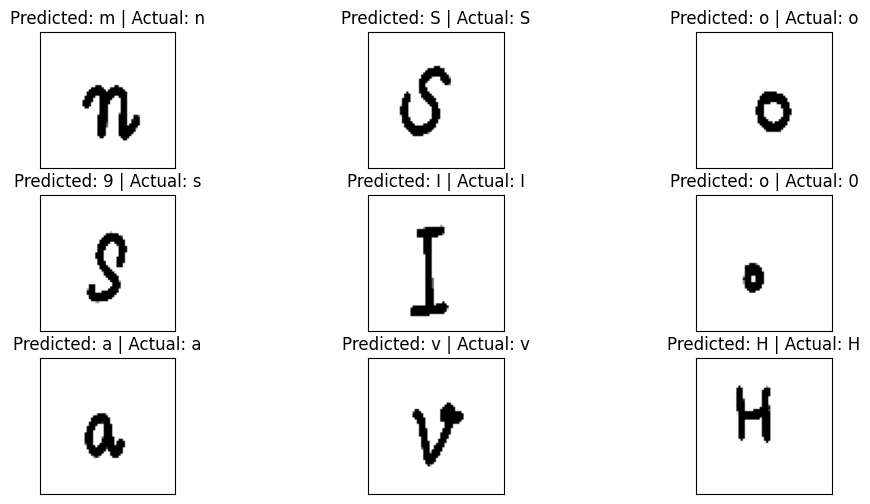

In [25]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Predicted: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

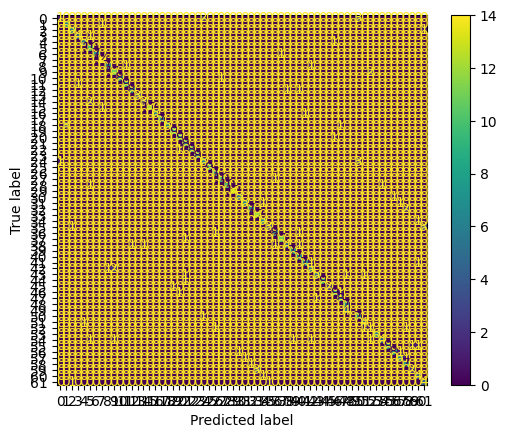

In [26]:
# Plot confusion matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis') 

In [27]:
# Save model to tfjs format and save as zip

# Save to tfjs format
tfjs.converters.save_keras_model(model, 'model_js')

# Convert output folder to zip
folder_to_zip = 'model_js'  
output_zip = 'model_js'  
shutil.make_archive(output_zip, 'zip', folder_to_zip)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/kaggle/working/model_js.zip'

# Mnist classification using RBF

<div class="alert alert-block alert-info">
<b>Step 1: Import required libraries</b>



In [1]:
# Import required libraries
import os
import torch
import numpy as np
import torch.nn as nn
from time import time
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import torchvision
from sklearn.cluster import KMeans

<div class="alert alert-block alert-info">
<b>Step 2: Load MNIST dataset and data loader

</b>



In [4]:
# Looking for device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

cpu


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

<div class="alert alert-block alert-info">
<b>Step 3: Transform the training dataset to fit into K-Means

</b>



In [6]:
train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor())
X_train = train_data.data.reshape(-1, 784).double().to(device) / 255.0

# Cluster the data using KMeans with k=10
kmeans = KMeans(n_clusters=50)
kmeans.fit(X_train.cpu().numpy())

# find the cluster centers
clusters = kmeans.cluster_centers_.astype(float)
print(clusters.shape)

(50, 784)


In [ ]:
im

In [7]:
# make RBF network
class RBFnet(nn.Module):
    def __init__(self, clusters):
        super(RBFnet, self).__init__()
        # remember how many centers we have
        self.N = clusters.shape[0]
        # our mean and sigmas for the RBF layer
        self.sigs = nn.Parameter( torch.ones(self.N,dtype=torch.float64)*5, requires_grad=False ) # our sigmas
        self.mus = nn.Parameter( torch.from_numpy(clusters), requires_grad=False ) # our means
        
        self.linear = nn.Linear(self.N, 10, dtype=torch.float64)

    def forward(self, x):
        distances = torch.sqrt(((x.unsqueeze(1) - self.mus)**2).sum(dim=2))
        # Calculate the Gaussian activations
        res = torch.exp((-0.5) * (distances**2) / self.sigs**2)
        # Set any NaN values to 0 (in case self.sigs is zero)
        res[res != res] = 0.0
        
        out = self.linear(res)
        return out

In [8]:
model = RBFnet(clusters).to(device)

# criteria function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
# define training function 
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss and accuracy
        running_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        _, y_pred = torch.max(outputs, dim=1)
        correct += torch.sum(y_pred == labels).item()
        total += labels.size(0)
    
    train_acc = 100 * (correct/total)
    train_loss = running_loss / len(train_loader)

    return train_acc, train_loss

In [10]:
# define testing function
def test(model, test_loader, optimizer, criterion):
    model.eval()
    true_y = []
    predicted_y = []

    batch_loss = 0
    total_t = 0
    correct_t = 0

    with torch.no_grad():
        for i, (images_t, labels_t) in enumerate(test_loader):
            images_t = images_t.view(-1, 784)
            images_t = images_t.to(device)
            labels_t = labels_t.to(device)

            # Forward pass
            outputs_t = model(images_t)
            loss_t = criterion(outputs_t, labels_t)

            # Loss and accuracy
            batch_loss += loss_t.item()
            y_actual = labels_t.data.cpu().numpy()
            _, y_pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(y_pred_t == labels_t).item()
            total_t += labels_t.size(0)
            true_y.extend(y_actual)
            predicted_y.extend(y_pred_t.cpu().numpy())
        
        test_acc = (100 * correct_t / total_t)
        test_loss = (batch_loss / len(test_loader))

    return test_acc, test_loss, true_y, predicted_y

In [11]:
val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []

recall_scores = []
precision_scores = []
f1_scores = []

num_epochs = 20
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc, val_loss, true_y, predicted_y = test(model, test_loader, optimizer, criterion)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}, Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(
        epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
    recall = recall_score(true_y, predicted_y, average='micro')
    precision = precision_score(true_y, predicted_y, average='micro')
    f1 = f1_score(true_y, predicted_y, average='micro')
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

Epoch [1/20], Train Loss: 0.8929, Train Acc: 76.14, Test Loss: 0.6001, Test Acc: 81.96%
Epoch [2/20], Train Loss: 0.5429, Train Acc: 83.83, Test Loss: 0.4940, Test Acc: 84.65%
Epoch [3/20], Train Loss: 0.4755, Train Acc: 85.60, Test Loss: 0.4483, Test Acc: 86.24%
Epoch [4/20], Train Loss: 0.4419, Train Acc: 86.54, Test Loss: 0.4211, Test Acc: 86.97%
Epoch [5/20], Train Loss: 0.4208, Train Acc: 87.10, Test Loss: 0.4023, Test Acc: 87.36%
Epoch [6/20], Train Loss: 0.4059, Train Acc: 87.54, Test Loss: 0.3883, Test Acc: 87.85%
Epoch [7/20], Train Loss: 0.3945, Train Acc: 87.85, Test Loss: 0.3772, Test Acc: 88.13%
Epoch [8/20], Train Loss: 0.3854, Train Acc: 88.06, Test Loss: 0.3682, Test Acc: 88.52%
Epoch [9/20], Train Loss: 0.3779, Train Acc: 88.28, Test Loss: 0.3607, Test Acc: 88.85%
Epoch [10/20], Train Loss: 0.3715, Train Acc: 88.46, Test Loss: 0.3543, Test Acc: 89.12%
Epoch [11/20], Train Loss: 0.3660, Train Acc: 88.58, Test Loss: 0.3487, Test Acc: 89.23%
Epoch [12/20], Train Loss: 0.3

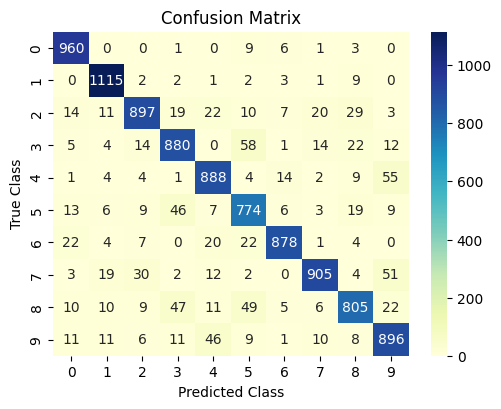

In [14]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
cf_matrix = confusion_matrix(true_y, predicted_y)

dataframe = pd.DataFrame(cf_matrix, index=classes, columns=classes)
plt.figure(figsize=(5, 4))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()